<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="5" color="black"><b>Use WML online scoring on CPD to predict Iris species on streaming data</b></th>
</table>

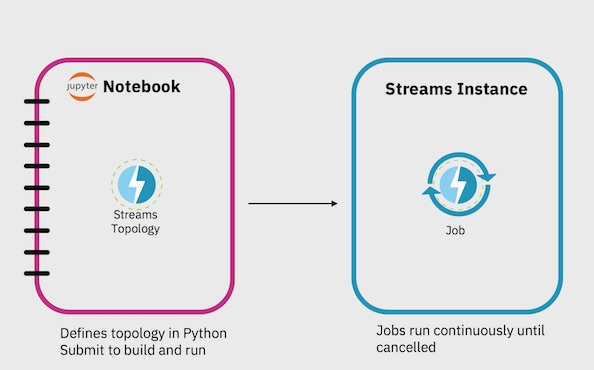
This notebook is based on the [WML sample notebook](https://github.com/pmservice/wml-sample-notebooks/blob/master/Use%20PMML%20to%20predict%20Iris%20species.ipynb) which shows storing, deploying and online scoring  of the Iris PMML model.
It is extended by a section which is using the deployed model to determine the parameters for best performance when handling streaming data.
A further section creates a Streaming Analytics application which is using the deployment to score online streaming data.


Some familiarity with python is helpful. This notebook uses **Python 3.6**.

You will use the **Iris** data set to predict the species of an iris flower. This data set contains measurements of the iris perianth flower. 

## Learning goals

You will learn how to:

-  Work with the Watson Machine Learning (WML) instance
  -  Store a PMML model in WML repository
  -  Deploy the stored model as Online Deployment 
  -  Score single data with the deployed model to test the deployment
-  Test the deployed model and its performance in the notebook with the streamsx.wml Python package
-  Create a Streaming Application with streamsx.wml Python package and deploy it


## Contents

1.	[Work with the WML service instance](#instance) 
  1.  [Store the model](#store)
  2.  [Create a deployment](#deploy)
  3.  [Single score test](#singlescore)
  
2.  [Test the deployment and its performance for streaming data](#test)

3.  [Create and run a Streaming Analytics application using this WML online scoring deployment](#application)

4.	[Summary and next steps](#summary)


<a id="instance"></a>
# 1. Working with the WML service instance

In this section you will learn which information is necessary to connect to WML in CPD and which steps are needed to use the WML API client.

You will create and use some WML artifacts (space, model, deployment) which need to have own name. The notebook defines these names in next cells, they will be used in the code of the notebook later. If you want to use your own name you can change them there.

In [ ]:
SPACE_NAME = "STREAMS_WML_SAMPLE_SPACE"
MODEL_NAME = "STREAMS_WML_SAMPLE_MODEL"
DEPLOYMENT_NAME = "STREAMS_WML_SAMPLE_DEPLOYMENT"

**Authenticate to the WML service on CPD**

Running in a Jupyter notebook in CPD you can use the token from the Jupyter environment. This token identifies you in CPD.
Below you find the WML credential informations needed to connect to WML in CPD.
The WML service URL is addressed by the CPD internal URL (same for all CPD instances), so you don't take care for this.
The instance id is a fix value and the version also.

In [ ]:
import os

userToken = os.environ["USER_ACCESS_TOKEN"]

wml_credentials = {
                   "url": "https://internal-nginx-svc:12443", # access the main CP4D proxy/the CP4D cluster root from internal side
                   "token": userToken,
                   "instance_id": "openshift",
                   "version" : "3.5"
                  }

**Connect to WML in CPD using the WML API client**

Create a WML client by using your credentials.

To work with the client you need also to set a **SPACE** your client should use.
A **SPACE** is where you can train, store and deploy your models. 
You can have different **SPACES** depending on your needs (e.g. one for TEST and one for PRODUCTION).

This notebook creates the space for you if it doesn't exist.

In [ ]:
from ibm_watson_machine_learning import APIClient
wml_client = APIClient(wml_credentials)
wml_client.version

**1.0.1 Create new space**

If you have a space already, please skip the cell below and continue with **1.0.2** 

In [ ]:
space_metadata = {
    'name': SPACE_NAME,
    'description': DEPLOYMENT_NAME,
}
space_details = wml_client.spaces.store(space_metadata)
print(space_details)

In [ ]:
space_id = wml_client.spaces.get_id(space_details)
print(space_id)

In order to check if the space creation is completed succesfully change next cell format to code and execute it. It should return 'active'.

In [ ]:
wml_client.spaces.get_details(space_id)['entity']['status']['state']

**1.0.2 Use existing space**

If you didn't create new space in this notebook by ibm_watson_machine_learning, please assign space ID below.

In [ ]:
wml_client.spaces.list()

In [ ]:
#space_id = 'PASTE YOUR SPACE ID HERE'

**Set default space:** To be able to interact with all resources available in Watson Machine Learning, you need to set space which you will be using

In [ ]:
wml_client.set.default_space(space_id)

Get information about the stored models for your WML instance.

In [ ]:
# List information about the stored models.
wml_client.repository.list_models()

Get a list of the deployed models for your WML service instance.

In [ ]:
# List the deployed models.
wml_client.deployments.list()

### Delete existing model and deployment

As WML doesn't prevent creation of models or deployments with same name the notebook deletes both if they exist.


In [ ]:
deployment_details = wml_client.deployments.get_details()
for deployment in deployment_details['resources']:
    deployment_id = deployment['metadata']['guid']
    model_id = deployment['entity']['asset']['href'].split('/')[3].split('?')[0]
    if deployment['entity']['name'] == DEPLOYMENT_NAME:
        print('Deleting deployment id', deployment_id)
        wml_client.deployments.delete(deployment_id)
        print('Deleting model id', model_id)
        wml_client.repository.delete(model_id)
wml_client.repository.list_models()

### 1.1. Store the model<a id="store"></a>

**Action**: Use `wget` to download the sample PMML model, `iris_chaid.xml` from the Git project.

In [ ]:
import os
from wget import download

sample_dir = 'pmml_sample_model'
if not os.path.isdir(sample_dir):
    os.mkdir(sample_dir)
    
filename=os.path.join(sample_dir, 'iris_chaid.xml')
if not os.path.isfile(filename):
    filename = download('https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cpd/models/pmml/iris-species/model/iris_chaid.xml', out=sample_dir)

In [ ]:
sw_spec_uid = wml_client.software_specifications.get_uid_by_name("spark-mllib_2.4")

meta_props = {
    wml_client.repository.ModelMetaNames.NAME: "pmmlmodel",
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sw_spec_uid,
    wml_client.repository.ModelMetaNames.TYPE: 'pmml_4.2.1'}

published_model = wml_client.repository.store_model(model=filename, meta_props=meta_props)

In [ ]:
wml_client.repository.list_models()

**Note:** From the list of downloaded files, you can see that model is successfully stored in the WML service repository.

### 1.2. Create the online deployment<a id="deploy"></a>

Now create the online deployment, *Iris species prediction*, for the stored model, then list all the online deployments for the model.

**Hint**

You give models as well as deployments a name. But the name is not checked if it already exists. The name not not the unique identifier, this is only the **guid** of a model and a deployment.
If you take care with your naming the name may be an identifier for you but you need for all API functions the **guid**.

In [ ]:
model_uid = wml_client.repository.get_model_uid(published_model)
deployment = wml_client.deployments.create(
    artifact_uid=model_uid,
    meta_props={
        wml_client.deployments.ConfigurationMetaNames.NAME: DEPLOYMENT_NAME,
        wml_client.deployments.ConfigurationMetaNames.ONLINE:{}}
)

wml_client.deployments.list()
deployment_id = wml_client.deployments.get_id(deployment)

**Note:** From the list of deployed models, you can see that model was  successfully created.

### 1.3. Score data<a id="singlescore"></a>

Send a sample record using the WML Python API client to check that the online scoring endpoint is available. Use here the **guid** of the just created deployment.

The data you will send for scoring defines the fields and the field values.
You get back the prediction as well as a set of probabilities.

In [ ]:
# Score data and predict species of flower.
scoring_data = [{'fields': ['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width'], 'values': [[5.1, 3.5, 1.4, 0.2]]}]

predictions = wml_client.deployments.score(deployment_id, meta_props={'input_data':scoring_data})

print(predictions)

As we can see from the prediction, this is the Iris Setosa flower.

<a id="test"></a>
# 2. Test the performance of your online scoring deployment

The streamsx.wml Python package allows you to use each WML online deployment to score streaming data. 
WML online scoring is based on a REST API. As such it has a poor performance when each input data is scored in single REST request.
But the performance of WML online scoring can be increased by 
-  sending multiple input data in one request (mini batch paradigm)
-  having multiple request sender 
-  deploying multple nodes

The streamsx.wml Python package is using all these possibilities to increase the WML REST performance.

The below performance test code can be used to determine the influence of different settings for number of input data in a request and request senders (Python threads).
If a suffiecient performance is found the appropriate settings can be taken as parameters for the Streaming Analytics application which will score your real time data.

There are some points to have in mind:
-  having a failure in a request with multiple input data will lead to fail the complete request 
-  so, the higher the number of input data in one request the higher the number to be processed afterwards one by one in case of failure, which takes longer time
-  so, input data quality is of high importance to use this mini batch paradigm
-  increasing thread number will work only to certain level, delays caused by Python thread handling will get important
-  actual input data sequence is kept, which may lead to postpone sending threads which got results earlier than the the ones with earlier data (especially when using multiple deployment nodes)
-  most important for throughput performance is the parameter __bundle_size__ which configures the maximal amount of tuples being bundled in one REST scoring request
-  The __bundle_size__ is only the upper limit. Each sending  thread having completet its work will grab from a queue as much tuples as are available upt to __bundle_size__. If there is only one in queue, which means that there is only low input rate, the thread will take this one for its next cycle.

The below code can be taken for any WML online deployment when __field_mapping_dict__ (which assigns streaming data attributes to the mining fields the model expects) and __class TestSource__ are changed according to the model which is deployed.

__space_guid__ and __deployment_guid__ are set by the code cells just ran before.


<div class="alert alert-block alert-info">
The test performance seen when running the test below will be higher as the one you will get when you use same parameters for the Streaming Application later. 
The reason is simple:
<ul>    
    <li> There is no resource intensive upstream or down stream processing.</li>
<li>At streaming application runtime each tuple has to be converted from its transport representation to Python object when received and from Python object/dictionary to transport representation when it is sent.</li>
</ul>
<p/>    
<b>You can assume that you'll get in your streaming application (created in chapter 3) approximately 1/2 of the performance you will see in this test chapter below.</b>
<p/>
<p> The performance varies on the used ML frame work as well as on the used model. You should test the deployment with different parameters for <b>bundle_size</b> and <b>threads_per_node</b>. The parameter <b>node_count</b> has to be changed only when you configured your WML deployment to use more than 1 node.  
</div>

In [ ]:
import streamsx.wml
streamsx.wml.__version__

In [ ]:
from streamsx.wml.bundleresthandler.wmlbundlecontroller import WmlBundleController
import streamsx.wml.utils as wml_utils
import threading
import json
import time


###################################################################################
# Parameters
#
# Collection all the parameters needed for using WML online scoring 
# resp. the underlying Rest Bundlehandler classes 
# 
# deployment_guid and space_guid are set by the code ran before.
# If you want to run this code w/o running the steps before you
# need to set the appropriate guids below and uncomment the 2 lines.
###################################################################################
#deployment_guid = <your_guid>
#space_guid = <your_guid>

field_mapping_dict =[{"model_field":"Sepal.Length",
                      "tuple_field":"sepal_length"},
                     {"model_field":"Sepal.Width",
                      "tuple_field":"sepal_width"},
                     {"model_field":"Petal.Length",
                      "tuple_field":"petal_length"},
                     {"model_field":"Petal.Width",
                      "tuple_field":"petal_width"}]


# streamsx.wml functions support field mapping as JSON 
field_mapping = json.dumps(field_mapping_dict)
# streamsx.wml functions support WML credentials as JSON 
wml_credentials = json.dumps(wml_utils.get_wml_credentials(version = '3.5'))  #token,url,instance_id,version

######################################################
# Callable class used by the REST handler threads.
# It's being called with the results of processed
# records bundle.
######################################################
class OutputClass:
    def __init__(self, interval):
        self._timer_interval = interval
        self._record_counter = 0
        self._result_1_counter = 0
        self._result_2_counter = 0
        self._time_a = time.time()
        self._last_count = 0
        self._timer = threading.Timer(interval,self._timer_action)
    
    def _timer_action(self):
        load = (self._record_counter - self._last_count) / (time.time() - self._time_a)
        print('Load(1/s): ', load, '   Records: ', self._record_counter, '   Records on output 1: ',self._result_1_counter,'   Failed records on output 2: ',self._result_2_counter)
         
    def __call__(self, results):
        if not self._timer.is_alive():
            self._timer = threading.Timer(self._timer_interval,self._timer_action)
            self._time_a = time.time()
            self._last_count = self._record_counter
            self._timer.start()
        for index,result_list in enumerate(results):
            # first returned list are the successful scored record 
            #(and ... depending on parameter single_output ... the failed)
            if index == 0:
                for list_element in result_list:
                    self._record_counter +=1
                    self._result_1_counter += 1
            # second returned list are the failed records 
            # if 'single_output = False'
            elif index == 1:
                for list_element in result_list:
                    self._record_counter +=1
                    self._result_2_counter += 1
            else:
                print("Internal error: More result lists generated than supported. ")
        


            
###################################################################################
# Test source
#
# Class with callable generating data as needed for the model which should be used.
# In streaming application the connect stream is the source.
###################################################################################
class TestSource:
    def __init__(self, ):
        pass
    def __call__(self):
            # run this indefinitely so that there will always be data for the view
        counter = 0
        while True:
            counter += 1
            record = {"petal_length":1.4,
                       "petal_width":0.2,
                       "sepal_length":5.1,
                       "sepal_width":3.5,
                       "number" : counter}
            # generate errors
            #if counter % 20 == 0:
            #    record.pop("petal_length",None)
            #    record.pop("sepal_length",None)

            #yield everytime same values, doesn't matter for test
            yield record


###################################################################################
# Test class
#
# The test application which is using the streamsx.wml WmlBundlerController, 
# same as the one used in function for Streaming Analytics applications provided by streamsx.wml
###################################################################################
class PerformanceTest:
    def __init__(self,source, **params):
        self._params = params
        self._source_generator = source()

    def _generate_data(self):
        while self._run:
            #for data in TestSource():
            self._testcontroller.process_data(next(self._source_generator))

    def start(self):
        self._testcontroller = WmlBundleController(**self._params)
        self._testcontroller.prepare()
        self._testcontroller.run()
        self._run = True
        self._source_thread = threading.Thread(target=self._generate_data)
        self._source_thread.start()

    def stop(self):
        self._run = False
        self._source_thread.join()
        self._testcontroller.stop()
        self._testcontroller.finish()


### Create a test instance with your parameters

In [ ]:
####################################################
# Dictionary of all parameters
#
# as used also in Streaming application
# except the 'output_function' parameter which is 
# added by the streaming operator as the output is
# special for any implementation using the 
# WmlBundleController
####################################################            
params= {
    'deployment_guid':deployment_id,
    'wml_credentials':wml_credentials,
    'space_guid':space_id,
    'bundle_size':  1000,
    'queue_size': 10000, 
    'threads_per_node': 2,
    'node_count':1,
    'field_mapping':field_mapping, 
    'output_function':OutputClass(interval=5.0 ),
    'single_output': False}

test = PerformanceTest(TestSource(), **params)

### Start the test

It will print every 5 secods a metrics as following:

`Load(1/s):  10194.683301388393    Records:  51000    Records on output 1:  51000    Failed records on output 2:  0`

It shows the actual determined load for the 5s intervall the records/input data processed in this time and the records/scoring results which were successful (output 1) and failed (output 2). Failed will be seen only when you set your __class TestSource__ to generate some error input data.

In [ ]:
test.start()

### Stop the test

__!!!Please stop the test before you change the parameters and start again!!!__

There are threads running which need to be stopped!

In [ ]:
test.stop()

<a id="application"></a>
# 3. Create and run a Streaming Analytics application using this WML online scoring deployment


<a id="setup"></a>

## 3.1. Setup

  
  
<div class="alert alert-block alert-info">
<b>What do we need to set up for our sample application?</b>  
<ul>    
<li>A connection to a running <b>IBM Streams instance</b> <br> 
   This notebook describes using a Streams instance in IBM Cloud Pak for Data.</li>
<li><b>streamsx</b> - the Python package providing the IBM Streams standard/basic function set</li>
<li><b>streamsx.wml</b> - the Python package providing the IBM Streams WML online scoring functionality</li>
<li><b>Data set</b> with sample Iris data</li>
<li><b>WML deployment</b> of the PMML Iris species prediction model (done above) </li>
</ul>
</div>



<a id="setupStreams"></a>

### 3.1.1 Add credentials for the IBM Streams service

In order to submit a Streams application you need to provide the name of the Streams instance.

1. From the navigation menu, click **Services > Instances**.
2. Update the value of `streams_instance_name` in the cell below according to your Streams instance name.

In [ ]:
from icpd_core import icpd_util
streams_instance_name = "sample-streams" ## Change this to your Streams instance

try:
    cfg=icpd_util.get_service_instance_details(name=streams_instance_name, instance_type="streams")
except TypeError:
    cfg=icpd_util.get_service_instance_details(name=streams_instance_name)

<a id="setupPackages"></a>

### 3.1.2 Import  the `streamsx` and `streamsx.wml` package and verify the package version

In [ ]:

import streamsx.topology.context
import streamsx.wml
print("INFO: streamsx package version: " + streamsx.topology.context.__version__)
print("INFO: streamsx.wml package version: " + streamsx.wml.__version__)

<a id="setupDataModel"></a>

### 3.1.3 Add test data your project


In [ ]:
# Download sample data from Git.
import wget, os

sample_dir = 'pmml_sample_model'
if not os.path.isdir(sample_dir):
    os.mkdir(sample_dir)
    
filename_data=os.path.join(sample_dir, 'iris.csv')
if not os.path.isfile(filename_data):
    filename_data = wget.download('https://ibm.box.com/shared/static/nnxx7ozfvpdkjv17x4katwu385cm6k5d.csv', out=sample_dir)

<a id="create"></a>

## 3.2. Create the application


All Streams applications start with  a `Topology` object, so we start by creating one.<br>Additionally we add our data set to the topology as a dependency, which means that is bundled within the built application and so available at the environment where the application will run.

In [ ]:
from streamsx.topology.topology import Topology
import os

topo = Topology(name="WMLScoring", namespace="sample")

# add files to be contained in the archive which is deployed to the node running the application
# in this sample we need the Iris `dataset` with sample data to be present at the worker node
topo.add_file_dependency(filename_data, 'etc')

<a id="defineInput"></a>

### 3.2.1 Define Data Input 

Let's take a look at the sample data, a set of measured data records:

In [ ]:
sample_data = filename_data
!head $sample_data

We will use this CSV file as data source for this sample. To simulate an endless stream of data we will read the file repeatedly and submit each line in the file as a tuple. The class below reads the data set and produces a stream of Python `dict` objects. The produced `Stream` is a stream of Python `dict`.

`Stream data : {"sepal_length" : <sepal_length_input>,
               "sepal_width"  : <sepal_width_input>, 
               "petal_length" : <petal_length_input>,
               "petal_width"  : <petal_width_input>,
               "referenceSpecies" : <species_target>,
               "Prediction" : ""}`

"Prediction" will be the field which contains the result from scoring. Depending on model and model framework the "Prediction" may be single value or a dictionary of multiple values.

In [ ]:
import csv
from streamsx.ec import get_application_directory
import time 

# a class which can be used in topology as a source
class CSVFileReader:
    def __init__(self, file_name):
        self.file_name = file_name
    def __call__(self):
        # Convert each row in the file to a dict
        drug_file =  os.path.join(get_application_directory(), "etc", self.file_name)
        col_names = ["sepal_length", "sepal_width", "petal_length", "petal_width", "referenceSpecies"]
       
        # run this indefinitely so that there will always be data for the view
        while True:
            with open(drug_file) as handle:
                reader = csv.DictReader(handle, delimiter=',',
                                                fieldnames=col_names)
                #Use this to skip the header line if your file has one
                next(reader)
                #yield the lines in the file one at a time
                #throttle
                throttle_count = 0
                for row in reader:
                    throttle_count += 1
                    if throttle_count % 4 is 0:
                        throttle_count = 0
                        time.sleep(0.0001)
                    yield dict(sepal_length= float(row["sepal_length"]),
                                     sepal_width = float(row["sepal_width"]), 
                                    petal_length= float(row["petal_length"]),
                                    petal_width=float(row["petal_width"]) ,
                                    referenceSpecies=row["referenceSpecies"],
                                    predictedSpecies="")

# let the csv file reader the source/edge node in our topology, producing the 'records' stream                    
records = topo.source(CSVFileReader("iris_initial.csv"))

# Let the source run in separate Python interpreter instance.
# streamsx.wml.wml_online_scoring() is a Python function and for bestt performance it will need all available ressources of an own Python interpreter instance.
records.isolate()


<a id="analyzeData"></a>
### 3.2.2 Score data and run the application


Now that we have created a stream of Iris data records, we need to define the analytics we want to perform on our data. Our WML deployment (PMML model) is predicting the Iris species from the measured data.  

<div class="alert alert-block alert-info">
<p>These are the core steps you need for using WML model scoring in your application:</p>
<ul>
    <li><b>Data preparation</b><br>Make sure your input stream meets your deployments (models) expected input features
    </li>
    <li><b>Score using <code>streamsx.wml.wml_online_scoring()</code>, specifying: </b><br>
        - the input stream which should be processed <b>mandatory</b><br>
        - the deployment_guid of the deployment we want to use <b>mandatory</b><br>
        - the field_mapping from input stream fields to model input features <b>mandatory</b><br>
        - the credentials to get access to the deployment <b>mandatory</b><br>
        - the space_guid of the deployment <b>mandatory</b><br>
        - the queue_size <br>
        - the bundle_size to configure the maximum tuples in one scoring request<br>
        - the threads_per_node to configure the number of threads used to send request to WML REST endpoint<br>
        - the node_count if you configured you WML deployment to use more than 1 node<br>
    </li>
</ul>

<p>In the code below we use values which were seen to give a good performance. It is assumed that there is one deployment node created. You may later play around with the values to see if they match the expectations you have from the performance test before</p>
    
</div>

In [ ]:
from streamsx.topology import context
import streamsx.wml.utils as wml_utils
import json

#####################################################################################
# Define the parameter for the scoring function
#####################################################################################
field_mapping_dict =[{"model_field":"Sepal.Length",
                      "tuple_field":"sepal_length"},
                     {"model_field":"Sepal.Width",
                      "tuple_field":"sepal_width"},
                     {"model_field":"Petal.Length",
                      "tuple_field":"petal_length"},
                     {"model_field":"Petal.Width",
                      "tuple_field":"petal_width"}]

# streamsx.wml.wml_online_scoring() support field mapping as JSON or dict
field_mapping = json.dumps(field_mapping_dict)

# streamsx.wml.wml_online_scoring() functions support WML credentials as JSON or dict
wml_credentials = json.dumps(wml_utils.get_wml_credentials(version = '3.5'))  #token,url,instance_id,version

# function call parameter
params= {
    'deployment_guid':deployment_id, #the one from the cells run above
    'field_mapping':field_mapping, 
    'credentials':wml_credentials,
    'space_guid':space_id,           #the one from the cells run above
    'bundle_size':  1000,
    'queue_size': 10000, 
    'threads_per_node': 2,
    'node_count':1,
    'single_output': False}


#####################################################################################
# Add the scoring function to your topology
#
# 2 result streams are generated: 
#        1st for successful scorings, 
#        2nd for failed scorings or invalid input
####################################################################################
scorings,invalids = streamsx.wml.wml_online_scoring(records, 
                                                  **params)
# for best load results in this test application
# separate the scoring from down stream functionality of publish() and view()
scorings.isolate()
scorings_mapped = scorings.map(lambda x: x)

# publish results as JSON
scorings_mapped.publish(topic="ScoredRecords",schema=json,name="PublishScores")
score_view = scorings_mapped.view(name="ScoredRecords", description="Sample of scored records")


# Disable SSL certificate verification if necessary
cfg[context.ConfigParams.SSL_VERIFY] = False


#####################################################################################
# Build and submit your topology
#####################################################################################
submission_result = context.submit('DISTRIBUTED', 
                                   topo, 
                                   cfg)

print(submission_result)

## 3.3 Use the View to access data from the job

Now that the job is started, use the View object you have already created to start retrieving successfully scored data.

In [ ]:
# Connect to the view and display the selected data
queue = score_view.start_data_fetch()
try:
    for val in range(20):
        print(queue.get(timeout=60))    
finally:
    score_view.stop_data_fetch()


## 3.4 See job status

You can view job status and logs by going to **Projects > Jobs**. Find your job based on the name printed above. Retrieve job logs using the "Download logs" action from the job's context menu.

To view other information about the job such as detailed metrics, access the graph. Go to **Projects > Jobs**. Select "View graph" action for the running job


## 3.5 Cancel the application
The Streams job is running in the Streams service. You can cancel it within the notebook or delete it from **Projects > Jobs**.

In [ ]:
# cancel the job in the IBM Streams service
submission_result.cancel_job_button()

## 3.6 Delete existing space
You can use the command below to delete existing space. You need to provide space_id of the space you want to delete.

In [ ]:
wml_client.spaces.delete(space_id)

<a id="summary"></a>
# 4. Summary and next steps     

You successfully completed this notebook! 
<p>You learned how to use Watson Machine Learning for PMML model storage, deployment and scoring.</p>
<p>You have further used the deployment to run a performance test in this notebook to see how many scorings per second can be reached with the WML provided <b>mini-batch</b> approach.</p>
<p>Last you have created a Streaming Analytics application which is using the WML deployment for online scoring of its streaming data. You saw that you can use same parameters set in performance test.</p>


### Citations

Dua, D. and Karra Taniskidou, E. (2017). [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science.


Copyright © 2020 IBM. This notebook and its source code are released under the terms of the MIT License.